## Check MITgcm single model on MITgcmdata, with window size 3 

In [1]:
import sys 
sys.path.append('../modules/')

In [2]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [3]:
%reload_ext autoreload
%autoreload 2
import evaluation

2024-02-05 22:08:44.846420: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-05 22:08:44.846462: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-05 22:08:44.846467: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
#model_nc  = '/home/jovyan/mesoscale_buoyancy_param_ML/ML_model_ncs/MOM6_P2L_all_36_36.nc'
data_kind = 'MITgcm' 
exp_name  = '' 
ML_name   = 'single'

In [41]:
eval_dic = {}
Lkeys = ['50', '100', '200', '400']
for L in Lkeys: 
    model_nc  = '/home/jovyan/mesoscale_buoyancy_param_ML/ML_model_ncs/MITgcm_'+L+'_window_3.nc'
    data_zarr = 'gs://leap-persistent/dhruvbalwada/m2lines_transfer/ML_data/ds_ML_'+L+'km_3D'
    eval_dic[L] = evaluation.full_reader(model_nc, data_zarr, L, data_kind, exp_name, ML_name,
                                        Tdim='time', windowed=True)

Dataset loaded from gs://leap-persistent/dhruvbalwada/m2lines_transfer/ML_data/ds_ML_50km_3D
Centered
Normalized data
Dataset loaded from gs://leap-persistent/dhruvbalwada/m2lines_transfer/ML_data/ds_ML_100km_3D
Centered
Normalized data
Dataset loaded from gs://leap-persistent/dhruvbalwada/m2lines_transfer/ML_data/ds_ML_200km_3D
Centered
Normalized data
Dataset loaded from gs://leap-persistent/dhruvbalwada/m2lines_transfer/ML_data/ds_ML_400km_3D
Centered
Normalized data


In [42]:
import matplotlib.pyplot as plt
import numpy as np

In [43]:
eval_dic['50'].output_ds

<xarray.Dataset>
Dimensions:  (time: 50, Z: 26, YC: 188, XC: 200)
Coordinates:
    Depth    (YC, XC) float32 2.985e+03 2.985e+03 ... 2.985e+03 2.985e+03
    PHrefC   (Z) float32 2.217e+03 2.668e+03 3.208e+03 ... 2.474e+04 2.575e+04
  * XC       (XC) float32 5e+03 1.5e+04 2.5e+04 ... 1.985e+06 1.995e+06
  * YC       (YC) float32 6.5e+04 7.5e+04 8.5e+04 ... 1.925e+06 1.935e+06
  * Z        (Z) float32 -226.0 -272.0 -327.0 ... -2.522e+03 -2.624e+03
    drF      (Z) float32 42.0 50.0 60.0 72.0 85.0 ... 103.0 103.0 103.0 103.0
    hFacC    (Z, YC, XC) float32 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    maskC    (Z, YC, XC) float64 dask.array<chunksize=(26, 188, 200), meta=np.ndarray>
    rA       (YC, XC) float32 1e+08 1e+08 1e+08 1e+08 ... 1e+08 1e+08 1e+08
  * time     (time) timedelta64[ns] 66363 days 66375 days ... 66951 days
Data variables:
    Sfnx     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 26, 187, 199), meta=np.ndarray>
    Sfny     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 26, 187, 199), meta=np.ndarray>

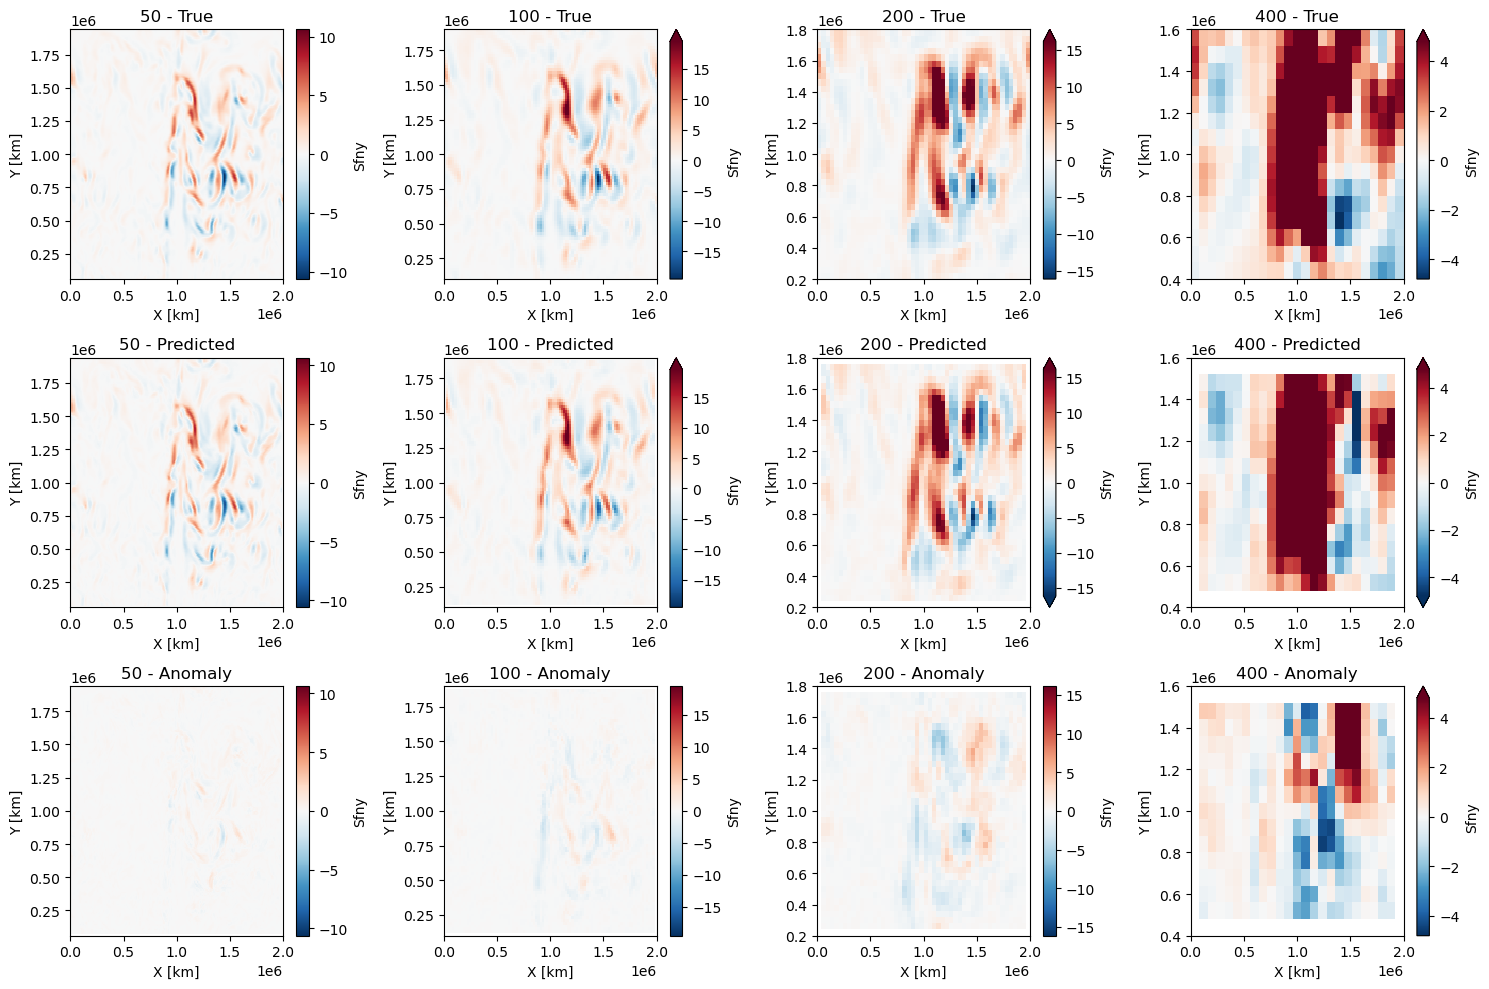

In [44]:
# Create a figure and axis objects
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))

# Iterate through the keys '50km', '100km', '200km', and '400km' and plot each dataset
for i, key in enumerate(['50', '100', '200', '400']):
    values = eval_dic[key]
    ds_true = values.output_ds.Sfny.isel(time=-1, Z=10)
    ds_pred = values.output_pred_ds.Sfny.isel(time=-1, Z=10)
    ds_anomaly = ds_true - ds_pred

    # Plotting true values
    ds_true.plot(ax=axs[0,i], vmin=ds_true.min().values)
    axs[0,i].set_title(f'{key} - True')
    
    # Plotting predicted values
    ds_pred.plot(ax=axs[1,i], vmin=ds_true.min().values)
    axs[1,i].set_title(f'{key} - Predicted')
    
    # Plotting anomaly values
    ds_anomaly.plot(ax=axs[2,i], vmin=ds_true.min().values)
    axs[2,i].set_title(f'{key} - Anomaly')
    
    # Set title and labels
    for j in range(3):
        axs[j,i].set_xlabel('X [km]')
        axs[j,i].set_ylabel('Y [km]')

    
# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
#plt.show()

#plt.savefig('./figures/data_MOM6p2l_ML_MOM6all_panels.png')

In [45]:
Lkeys = ['50', '100', '200', '400']
print('R2:')
for L in Lkeys: 
    print(L + ': ' + str(eval_dic[L].calc_R2(dims=['time','XC','YC','Z']).values) )

R2:
50: 0.96009946
100: 0.9634094
200: 0.93439674
400: 0.9021232


In [46]:
Lkeys = ['50', '100', '200', '400']
print('Corr:')
for L in Lkeys: 
    print(L + ': ' + str(eval_dic[L].calc_corr(dims=['time','XC','YC','Z']).values) )

Corr:
50: 0.9801416
100: 0.98212945
200: 0.96890616
400: 0.9536623


## Scraps

In [7]:
model_nc  = '/home/jovyan/mesoscale_buoyancy_param_ML/ML_model_ncs/MITgcm_'+L+'_window_3.nc'

In [8]:
temp = evaluation.EvaluationSystem()

In [9]:
temp.read_model(model_nc)

In [10]:
temp.model_xr

<xarray.Dataset>
Dimensions:       (num_layers: 4, input: 54, layer1: 24, layer2: 24, output: 2,
                   input_channels: 6)
Dimensions without coordinates: num_layers, input, layer1, layer2, output,
                                input_channels
Data variables:
    layer_sizes   (num_layers) int32 ...
    A0            (input, layer1) float32 ...
    A1            (layer1, layer2) float32 ...
    A2            (layer2, output) float32 ...
    b0            (layer1) float32 ...
    b1            (layer2) float32 ...
    b2            (output) float32 ...
    input_norms   (input_channels) float32 ...
    output_norms  (output) float32 ...
Attributes:
    CKPT_DIR:         /home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints...
    shape:            [24 24  2]
    num_in:           6
    input_channels:   ['U_x', 'U_y', 'V_x', 'V_y', 'Sx', 'Sy']
    output_channels:  ['Sfnx', 'Sfny']

In [11]:
temp.get_model_norm_factors_ds()

In [ ]:
temp.win

In [18]:
temp.read_eval_data_windowed(data_zarr, L, data_kind)

Dataset loaded from gs://leap-persistent/dhruvbalwada/m2lines_transfer/ML_data/ds_ML_50km_3D
Centered
Normalized data


In [20]:
temp.input_ds_normed

<xarray.Dataset>
Dimensions:  (time: 495, Z: 26, YC: 188, XC: 200, Xn: 3, Yn: 3)
Coordinates:
    Depth    (YC, XC) float32 2.985e+03 2.985e+03 ... 2.985e+03 2.985e+03
    PHrefC   (Z) float32 2.217e+03 2.668e+03 3.208e+03 ... 2.474e+04 2.575e+04
  * XC       (XC) float32 5e+03 1.5e+04 2.5e+04 ... 1.985e+06 1.995e+06
  * YC       (YC) float32 6.5e+04 7.5e+04 8.5e+04 ... 1.925e+06 1.935e+06
  * Z        (Z) float32 -226.0 -272.0 -327.0 ... -2.522e+03 -2.624e+03
    drF      (Z) float32 42.0 50.0 60.0 72.0 85.0 ... 103.0 103.0 103.0 103.0
    hFacC    (Z, YC, XC) float32 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    maskC    (Z, YC, XC) float64 dask.array<chunksize=(26, 188, 200), meta=np.ndarray>
    rA       (YC, XC) float32 1e+08 1e+08 1e+08 1e+08 ... 1e+08 1e+08 1e+08
  * time     (time) timedelta64[ns] 61023 days 61035 days ... 66951 days
Dimensions without coordinates: Xn, Yn
Data variables:
    U_x      (time, Z, YC, XC, Xn, Yn) float32 dask.array<chunksize=(1, 26, 187, 199, 3, 3), meta=np.ndarray>
    U_y      (time, Z, YC, XC, Xn, Yn) float32 dask.array<chunksize=(1, 26, 187, 199, 3, 3), meta=np.ndarray>
    V_x      (time, Z, YC, XC, Xn, Yn) float32 dask.array<chunksize=(1, 26, 187, 199, 3, 3), meta=np.ndarray>
    V_y      (time, Z, YC, XC, Xn, Yn) float32 dask.array<chunksize=(1, 26, 187, 199, 3, 3), meta=np.ndarray>
    Sx       (time, Z, YC, XC, Xn, Yn) float32 dask.array<chunksize=(1, 26, 187, 199, 3, 3), meta=np.ndarray>
    Sy       (time, Z, YC, XC, Xn, Yn) float32 dask.array<chunksize=(1, 26, 187, 199, 3, 3), meta=np.ndarray>

In [21]:
temp.eval_ds.ML_dataset

<xarray.Dataset>
Dimensions:  (YC: 188, XC: 200, Z: 26, time: 495, Xn: 3, Yn: 3)
Coordinates:
    Depth    (YC, XC) float32 2.985e+03 2.985e+03 ... 2.985e+03 2.985e+03
    PHrefC   (Z) float32 2.217e+03 2.668e+03 3.208e+03 ... 2.474e+04 2.575e+04
  * XC       (XC) float32 5e+03 1.5e+04 2.5e+04 ... 1.985e+06 1.995e+06
  * YC       (YC) float32 6.5e+04 7.5e+04 8.5e+04 ... 1.925e+06 1.935e+06
  * Z        (Z) float32 -226.0 -272.0 -327.0 ... -2.522e+03 -2.624e+03
    drF      (Z) float32 42.0 50.0 60.0 72.0 85.0 ... 103.0 103.0 103.0 103.0
    hFacC    (Z, YC, XC) float32 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    maskC    (Z, YC, XC) float64 dask.array<chunksize=(26, 188, 200), meta=np.ndarray>
    rA       (YC, XC) float32 1e+08 1e+08 1e+08 1e+08 ... 1e+08 1e+08 1e+08
  * time     (time) timedelta64[ns] 61023 days 61035 days ... 66951 days
Dimensions without coordinates: Xn, Yn
Data variables:
    Sfnx     (time, Z, YC, XC, Xn, Yn) float32 dask.array<chunksize=(1, 26, 187, 199, 3, 3), meta=np.ndarray>
    Sfny     (time, Z, YC, XC, Xn, Yn) float32 dask.array<chunksize=(1, 26, 187, 199, 3, 3), meta=np.ndarray>
    U_x      (time, Z, YC, XC, Xn, Yn) float32 dask.array<chunksize=(1, 26, 187, 199, 3, 3), meta=np.ndarray>
    U_y      (time, Z, YC, XC, Xn, Yn) float32 dask.array<chunksize=(1, 26, 187, 199, 3, 3), meta=np.ndarray>
    V_x      (time, Z, YC, XC, Xn, Yn) float32 dask.array<chunksize=(1, 26, 187, 199, 3, 3), meta=np.ndarray>
    V_y      (time, Z, YC, XC, Xn, Yn) float32 dask.array<chunksize=(1, 26, 187, 199, 3, 3), meta=np.ndarray>
    Sx       (time, Z, YC, XC, Xn, Yn) float32 dask.array<chunksize=(1, 26, 187, 199, 3, 3), meta=np.ndarray>
    Sy       (time, Z, YC, XC, Xn, Yn) float32 dask.array<chunksize=(1, 26, 187, 199, 3, 3), meta=np.ndarray>

In [22]:
temp.sel_time(slice(-10,None), 'time')

In [23]:
temp.input_ds_normed.to_stacked_array("input_features", sample_dims=['time','Z','YC','XC'])

<xarray.DataArray 'U_x' (time: 10, Z: 26, YC: 188, XC: 200, input_features: 54)>
dask.array<concatenate, shape=(10, 26, 188, 200, 54), dtype=float32, chunksize=(1, 26, 187, 199, 9), chunktype=numpy.ndarray>
Coordinates: (12/15)
    Depth           (YC, XC) float32 2.985e+03 2.985e+03 ... 2.985e+03 2.985e+03
    PHrefC          (Z) float32 2.217e+03 2.668e+03 ... 2.474e+04 2.575e+04
  * XC              (XC) float32 5e+03 1.5e+04 2.5e+04 ... 1.985e+06 1.995e+06
  * YC              (YC) float32 6.5e+04 7.5e+04 8.5e+04 ... 1.925e+06 1.935e+06
  * Z               (Z) float32 -226.0 -272.0 -327.0 ... -2.522e+03 -2.624e+03
    drF             (Z) float32 42.0 50.0 60.0 72.0 ... 103.0 103.0 103.0 103.0
    ...              ...
    rA              (YC, XC) float32 1e+08 1e+08 1e+08 ... 1e+08 1e+08 1e+08
  * time            (time) timedelta64[ns] 66843 days 66855 days ... 66951 days
  * input_features  (input_features) object MultiIndex
  * variable        (input_features) object 'U_x' 'U_x' 'U_x' ... 'Sy' 'Sy' 'Sy'
  * Xn              (input_features) int64 0 0 0 1 1 1 2 2 2 ... 0 0 1 1 1 2 2 2
  * Yn              (input_features) int64 0 1 2 0 1 2 0 1 2 ... 1 2 0 1 2 0 1 2

In [25]:
temp_data = temp.regress_sys.pred(temp.input_ds_normed.to_stacked_array("input_features", sample_dims=['time','Z','YC','XC']).data)

In [29]:
temp.eval_ds.window_size

3

In [27]:
temp.output_ds.isel(Xn=int(

<xarray.Dataset>
Dimensions:  (time: 10, Z: 26, YC: 188, XC: 200, Xn: 3, Yn: 3)
Coordinates:
    Depth    (YC, XC) float32 2.985e+03 2.985e+03 ... 2.985e+03 2.985e+03
    PHrefC   (Z) float32 2.217e+03 2.668e+03 3.208e+03 ... 2.474e+04 2.575e+04
  * XC       (XC) float32 5e+03 1.5e+04 2.5e+04 ... 1.985e+06 1.995e+06
  * YC       (YC) float32 6.5e+04 7.5e+04 8.5e+04 ... 1.925e+06 1.935e+06
  * Z        (Z) float32 -226.0 -272.0 -327.0 ... -2.522e+03 -2.624e+03
    drF      (Z) float32 42.0 50.0 60.0 72.0 85.0 ... 103.0 103.0 103.0 103.0
    hFacC    (Z, YC, XC) float32 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    maskC    (Z, YC, XC) float64 dask.array<chunksize=(26, 188, 200), meta=np.ndarray>
    rA       (YC, XC) float32 1e+08 1e+08 1e+08 1e+08 ... 1e+08 1e+08 1e+08
  * time     (time) timedelta64[ns] 66843 days 66855 days ... 66951 days
Dimensions without coordinates: Xn, Yn
Data variables:
    Sfnx     (time, Z, YC, XC, Xn, Yn) float32 dask.array<chunksize=(1, 26, 187, 199, 3, 3), meta=np.ndarray>
    Sfny     (time, Z, YC, XC, Xn, Yn) float32 dask.array<chunksize=(1, 26, 187, 199, 3, 3), meta=np.ndarray>

In [32]:
temp_data.shape

(10, 26, 188, 200, 2)

In [34]:
temp.output_ds.isel(Xn=1, Yn=1).to_array().transpose(...,'variable').dims

('time', 'Z', 'YC', 'XC', 'variable')

In [ ]:
eval_mod.read_eval_data(data_zarr,L, data_kind)

In [35]:
temp.pred_windowed()

In [36]:
temp.output_pred_ds

<xarray.Dataset>
Dimensions:  (YC: 188, XC: 200, Z: 26, time: 10)
Coordinates:
    Depth    (YC, XC) float32 2.985e+03 2.985e+03 ... 2.985e+03 2.985e+03
    PHrefC   (Z) float32 2.217e+03 2.668e+03 3.208e+03 ... 2.474e+04 2.575e+04
  * XC       (XC) float32 5e+03 1.5e+04 2.5e+04 ... 1.985e+06 1.995e+06
  * YC       (YC) float32 6.5e+04 7.5e+04 8.5e+04 ... 1.925e+06 1.935e+06
  * Z        (Z) float32 -226.0 -272.0 -327.0 ... -2.522e+03 -2.624e+03
    drF      (Z) float32 42.0 50.0 60.0 72.0 85.0 ... 103.0 103.0 103.0 103.0
    hFacC    (Z, YC, XC) float32 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    maskC    (Z, YC, XC) float64 dask.array<chunksize=(26, 188, 200), meta=np.ndarray>
    rA       (YC, XC) float32 1e+08 1e+08 1e+08 1e+08 ... 1e+08 1e+08 1e+08
  * time     (time) timedelta64[ns] 66843 days 66855 days ... 66951 days
Data variables:
    Sfnx     (time, Z, YC, XC) float32 nan nan nan nan nan ... nan nan nan nan
    Sfny     (time, Z, YC, XC) float32 nan nan nan nan nan ... nan nan nan nan

In [10]:
eval_dic['50'].eval_ds.norm_factors.Sfnx.values

KeyError: '50'

In [8]:
eval_dic['50'].model_xr.output_norms.values

array([1.103115 , 0.7384286], dtype=float32)

In [7]:
import matplotlib.pyplot as plt
import numpy as np

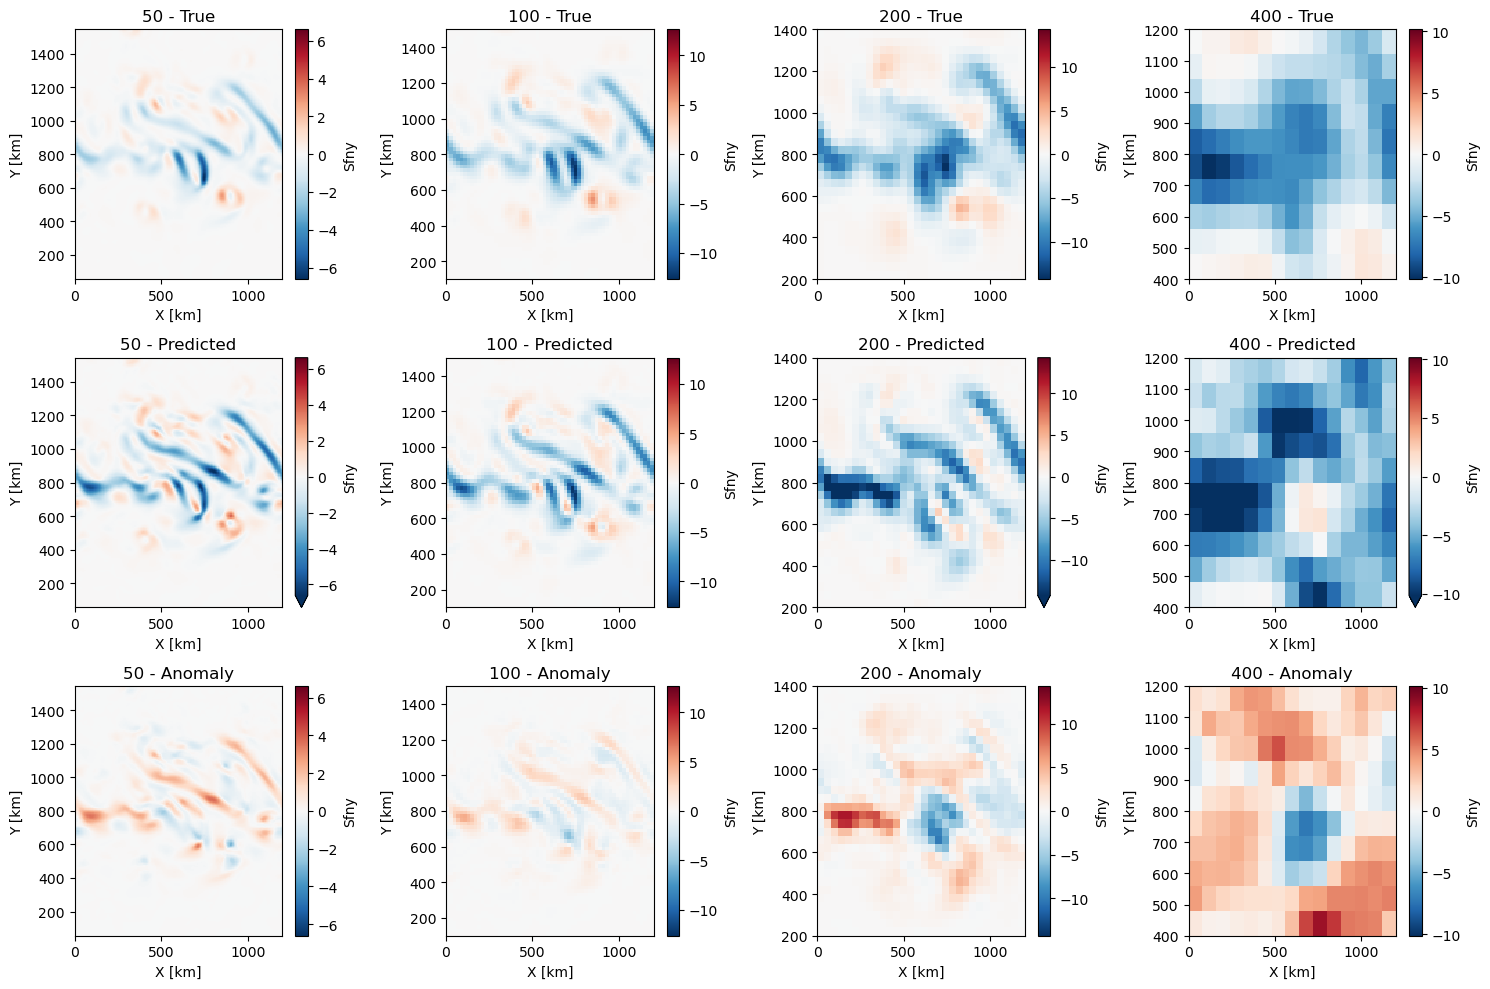

In [9]:
# Create a figure and axis objects
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))

# Iterate through the keys '50km', '100km', '200km', and '400km' and plot each dataset
for i, key in enumerate(['50', '100', '200', '400']):
    values = eval_dic[key]
    ds_true = values.output_ds.Sfny.isel(Time=-1)
    ds_pred = values.output_pred_ds.Sfny.isel(Time=-1)
    ds_anomaly = ds_true - ds_pred

    # Plotting true values
    ds_true.plot(ax=axs[0,i], vmin=ds_true.min().values)
    axs[0,i].set_title(f'{key} - True')
    
    # Plotting predicted values
    ds_pred.plot(ax=axs[1,i], vmin=ds_true.min().values)
    axs[1,i].set_title(f'{key} - Predicted')
    
    # Plotting anomaly values
    ds_anomaly.plot(ax=axs[2,i], vmin=ds_true.min().values)
    axs[2,i].set_title(f'{key} - Anomaly')
    
    # Set title and labels
    for j in range(3):
        axs[j,i].set_xlabel('X [km]')
        axs[j,i].set_ylabel('Y [km]')

    
# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
#plt.show()

#plt.savefig('./figures/data_MOM6p2l_ML_MOM6all_panels.png')